## Exploratory Data Analysis: Raw Features¶

In the previous step (see Workbook 2: Feature_Development), a relatively large number (~100) of features were created out of the cleaned raw data  (see Workbook 1: Data_Cleaning_Wrangling). 

What we will do here is look at heat mapping and scatter plots for the subset of these created features that represent the "raw" features for the two players matched up in the "upcoming" match, versus the target feature (% of points won in the "upcoming" match for a given player) in the "upcoming" match to be predicted on. "Raw" here means that these are the features independent of the value for the same feature for the opponent in a given match to be predicted on. A reminder that these "raw" features are computed ONLY on matches leading up to, but NOT including or after, the match being predicted on (a match which, of course, has already happened in the real world-hence the quotes around "upcoming".) All (or nearly all) of these "raw" features have "differential" counterparts for each individual player per match being predicted on as well. "Differential" means that each feature for each player is a SUBTRACTION of one opponent in the match being predicted on from the other. These "differential" counterparts are looked at in a separate EDA, and will be included at the modeling stage along with the "raw" features looked at here. 

As an additional reminder, these features are computed on various time windows leading up to the "upcoming" match, most with a decay function to emphasize more "recent" events relatively more than "older" events relative to the match being predicted on. At this point, the specific decay functions used per feature have been iterated based on feedback from EDA (correlation strengths) and simple (linear) modeling of predictive value for the target feature. Also, as a general rule, these features are computed in a surface-specific way- ie, only based on "past" hard court or clay court matches relative to the match being predicted on. An exception to this is the proxy for player "stamina" (# of matches played in the "past" across hard and clay surfaces in the overall sample, with a cap at 250 total). Also, another reminder that grass court matches were removed from the sample during the cleaning stage, as the sample is low and grass represents such a unique environment (also, I'll note again here that indoor and outdoor hardcourt matches are pooled together for the sake of feature development. This decision may be revisited later as themodel is refined and data size incrases). However, I will note to these ends, that a proxy for court speed (ace% the year previous at the same tournament, with a few "freakish" ace outlier players removed when present) is included in the overall dataset as a stand-alone feature. 

A final note- although the raw data and feature set includes matches from 2012-2019 inclusive, in the exploratory data analysis and modeling steps, only data from 2014-2019 will be included. The rationale for this is that some of the retrospective features relative to a match being predicted on are accrued from a large number of "periods" (matches) previous to the event being predicted on. Thus, a match "early" in this sample would have a number of features artificially truncated by running up against the beginning of the sample. In no way does this reflect reduced raw data quality in the earliest two years of the sample. Additionally, in the same vein, the first few matches (n=3) for a given player (AND for his opponent in those matches) in the entire sample are removed, since there are many NaN values for features accruing retrospectively. This accounts for a very small fraction of the total matches remaining in the sample after alreadt filtering out matches played in 2012 and 2013 from the EDA and modeling stages. Just to be clear, though, these excluded matches were filtered out AFTER retrospective feature accrual (ie, they go into feature calcultions intended for prediction on matches in future "periods"). 

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
df = pd.read_csv('../data/df_forEDA.csv')

### Summaries of Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36538 entries, 0 to 36537
Data columns (total 77 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   t_id                                                     36538 non-null  object 
 1   t_date                                                   36538 non-null  int64  
 2   tour_wk                                                  36538 non-null  object 
 3   t_name                                                   36538 non-null  object 
 4   t_country                                                36538 non-null  object 
 5   t_surf                                                   36538 non-null  int64  
 6   t_lvl                                                    36538 non-null  int64  
 7   t_draw_size                                              36538 non-null  int64  
 8   t_round                   

In [4]:
df.head()

,t_id,t_date,tour_wk,t_name,t_country,t_surf,t_lvl,t_draw_size,t_round,t_rd_num,...,p_bp_convert%_l60_diff,p_bp_save%_l60_opp_bp_convert%_l60_diff,p_bp_convert%_l60_opp_bp_save%_l60_diff,p_time_last_diff,p_tot_time_l5_decay_diff,p_pts_last_diff,p_tot_pts_l5_decay_diff,p_matches_diff,p_stam_adj_fatigue_diff,p_H2H_diff
0,2019-560,20190826,2019_24,US Open,USA,2,4,128,R128,1.0,...,NaN,NaN,NaN,-0.0,-0.00,-0.0,-0.00,-225.0,97.46,-0.0
1,2019-M014,20191014,2019_29,Moscow,RUS,2,1,32,R32,1.0,...,NaN,NaN,NaN,-0.0,-0.00,-0.0,-0.00,-0.0,-0.00,-0.0
2,2019-M004,20190225,2019_07,Acapulco,MEX,2,1,32,R32,1.0,...,NaN,NaN,NaN,-0.0,-0.00,-0.0,-0.00,-25.0,83.93,-0.0
3,2019-7696,20191105,2019_33,NextGen Finals,ITA,2,3,8,F,5.0,...,-9.75,21.45,-21.53,2.0,12.30,9.0,29.26,-80.0,19.13,0.0
4,2019-7696,20191105,2019_33,NextGen Finals,ITA,2,3,8,SF,4.0,...,-5.78,23.58,-17.52,45.0,19.78,53.0,26.93,-18.0,12.95,0.0


In [5]:
df.describe()

,t_date,t_surf,t_lvl,t_draw_size,t_rd_num,t_ace%_last,m_num,m_best_of,m_outcome,m_time(m),...,p_bp_convert%_l60_diff,p_bp_save%_l60_opp_bp_convert%_l60_diff,p_bp_convert%_l60_opp_bp_save%_l60_diff,p_time_last_diff,p_tot_time_l5_decay_diff,p_pts_last_diff,p_tot_pts_l5_decay_diff,p_matches_diff,p_stam_adj_fatigue_diff,p_H2H_diff
count,3.653800e+04,36538.000000,36538.000000,36538.000000,36488.000000,36538.000000,36538.000000,36538.000000,36538.000000,36536.000000,...,3.466600e+04,34678.000000,34678.000000,36538.00000,3.653800e+04,36538.000000,3.653800e+04,36538.000000,3.653800e+04,36538.000000
mean,2.015541e+07,1.648804,1.756801,59.471454,1.996218,7.389914,11507.173956,3.330286,0.500000,107.335778,...,7.474165e-16,16.984979,-16.984979,0.00000,-2.792543e-16,0.000000,-1.124796e-15,0.000000,-7.493194e-15,0.000000
std,2.297353e+04,0.477351,1.092249,38.551648,1.184185,1.876769,6762.498465,0.742630,0.500007,39.063750,...,1.082128e+01,10.813364,10.813364,35.57685,2.812110e+01,47.762308,3.772033e+01,102.376135,2.590963e+01,0.893852
min,2.012010e+07,1.000000,1.000000,8.000000,1.000000,3.100000,0.000000,3.000000,0.000000,28.000000,...,-7.595000e+01,-61.010000,-100.000000,-248.00000,-2.004800e+02,-330.000000,-2.531800e+02,-299.000000,-2.037100e+02,-12.000000
25%,2.013103e+07,1.000000,1.000000,32.000000,1.000000,5.660000,5673.000000,3.000000,0.000000,78.000000,...,-5.480000e+00,11.410000,-22.720000,-5.00000,-4.020000e+00,-6.000000,-4.912500e+00,-49.000000,-6.110000e+00,0.000000
50%,2.016010e+07,2.000000,1.000000,32.000000,2.000000,7.650000,11471.000000,3.000000,0.500000,100.000000,...,0.000000e+00,16.940000,-16.940000,0.00000,0.000000e+00,0.000000,-0.000000e+00,0.000000,0.000000e+00,0.000000
75%,2.018010e+07,2.000000,2.000000,64.000000,3.000000,8.480000,17397.000000,3.000000,1.000000,129.000000,...,5.480000e+00,22.720000,-11.410000,5.00000,4.020000e+00,6.000000,4.912500e+00,49.000000,6.110000e+00,0.000000
max,2.019111e+07,2.000000,4.000000,128.000000,7.000000,12.720000,23320.000000,5.000000,1.000000,353.000000,...,7.595000e+01,100.000000,61.010000,248.00000,2.004800e+02,330.000000,2.531800e+02,299.000000,2.037100e+02,12.000000


### Filter Data (see Introduction for Explanation)

In [6]:
df_filter = df[~df['tour_wk'].str.contains("2012")] 
df_filter = df_filter[~df_filter['tour_wk'].str.contains("2013")]

In [7]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27350 entries, 0 to 36536
Data columns (total 77 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   t_id                                                     27350 non-null  object 
 1   t_date                                                   27350 non-null  int64  
 2   tour_wk                                                  27350 non-null  object 
 3   t_name                                                   27350 non-null  object 
 4   t_country                                                27350 non-null  object 
 5   t_surf                                                   27350 non-null  int64  
 6   t_lvl                                                    27350 non-null  int64  
 7   t_draw_size                                              27350 non-null  int64  
 8   t_round                   

In [8]:
# We will also remove BOTH players from individual matches remaining in the sample (after removing the earliest two years, where matches and stats accrued)
# where one player has played 3 or fewer matches prior to the one to be predicted on. 

df_low = df_filter.loc[df_filter['p_matches'] <= 3, 'm_num']
df_low

df_filter = df_filter[~df_filter['m_num'].isin(df_low)]
df_filter

,t_id,t_date,tour_wk,t_name,t_country,t_surf,t_lvl,t_draw_size,t_round,t_rd_num,...,p_bp_convert%_l60_diff,p_bp_save%_l60_opp_bp_convert%_l60_diff,p_bp_convert%_l60_opp_bp_save%_l60_diff,p_time_last_diff,p_tot_time_l5_decay_diff,p_pts_last_diff,p_tot_pts_l5_decay_diff,p_matches_diff,p_stam_adj_fatigue_diff,p_H2H_diff
3,2019-7696,20191105,2019_33,NextGen Finals,ITA,2,3,8,F,5.0,...,-9.75,21.45,-21.53,2.0,12.30,9.0,29.26,-80.0,19.13,0.0
4,2019-7696,20191105,2019_33,NextGen Finals,ITA,2,3,8,SF,4.0,...,-5.78,23.58,-17.52,45.0,19.78,53.0,26.93,-18.0,12.95,0.0
5,2019-7696,20191105,2019_33,NextGen Finals,ITA,2,3,8,RR3,3.0,...,-8.37,23.93,-20.93,-46.0,-38.32,-65.0,-37.05,-16.0,1.18,-0.0
6,2019-7696,20191105,2019_33,NextGen Finals,ITA,2,3,8,RR2,2.0,...,-8.17,22.17,-15.05,-15.0,-10.05,13.0,8.71,-5.0,1.68,0.0
7,2019-7696,20191105,2019_33,NextGen Finals,ITA,2,3,8,RR1,1.0,...,-5.71,23.41,-29.02,0.0,0.00,0.0,0.00,-106.0,17.47,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36529,2014-439,20140721,2014_20,Umag,CRO,1,1,28,R32,1.0,...,-7.32,11.28,-25.93,-0.0,-0.00,-0.0,-0.00,-75.0,25.45,-0.0
36530,2014-414,20140714,2014_19,Hamburg,GER,1,1,48,SF,5.0,...,-3.98,11.92,-18.31,58.0,39.03,70.0,41.45,-189.0,62.03,-0.0
36531,2014-414,20140714,2014_19,Hamburg,GER,1,1,48,QF,4.0,...,-4.24,9.76,-18.96,-9.0,-8.66,-30.0,-25.03,-65.0,47.99,0.0
36532,2014-414,20140714,2014_19,Hamburg,GER,1,1,48,R16,3.0,...,-3.38,8.09,-20.96,37.0,23.79,14.0,7.38,-98.0,52.41,0.0


In [9]:
df_filter["p_matches"].min()

4.0

In [10]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25604 entries, 3 to 36533
Data columns (total 77 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   t_id                                                     25604 non-null  object 
 1   t_date                                                   25604 non-null  int64  
 2   tour_wk                                                  25604 non-null  object 
 3   t_name                                                   25604 non-null  object 
 4   t_country                                                25604 non-null  object 
 5   t_surf                                                   25604 non-null  int64  
 6   t_lvl                                                    25604 non-null  int64  
 7   t_draw_size                                              25604 non-null  int64  
 8   t_round                   

In [15]:
# Filtering down to just the RAW features
df_filter_raw = df_filter[["p_pts_won%", "p_rank", "p_rank_pts", "p_log_rank", "p_matches", "p_ent", "p_hand", "p_ht", "p_age", "p_pts_won%_l60_decay","p_sv_pts_won%_l60_decay", "p_ret_pts_won%_l60_decay", 'p_pts_won%_std_l60','p_sv_pts_won%_std_l60','p_ret_pts_won%_std_l60', "p_ace%_l60_decay", "p_aced%_l60_decay", "p_bp_save%_l60", "p_bp_convert%_l60", "p_m_time_last", "p_tot_time_l5_decay", "p_tot_pts_last", "p_tot_pts_l5_decay", "p_stamina_adj_fatigue", "p_H2H_w"]]

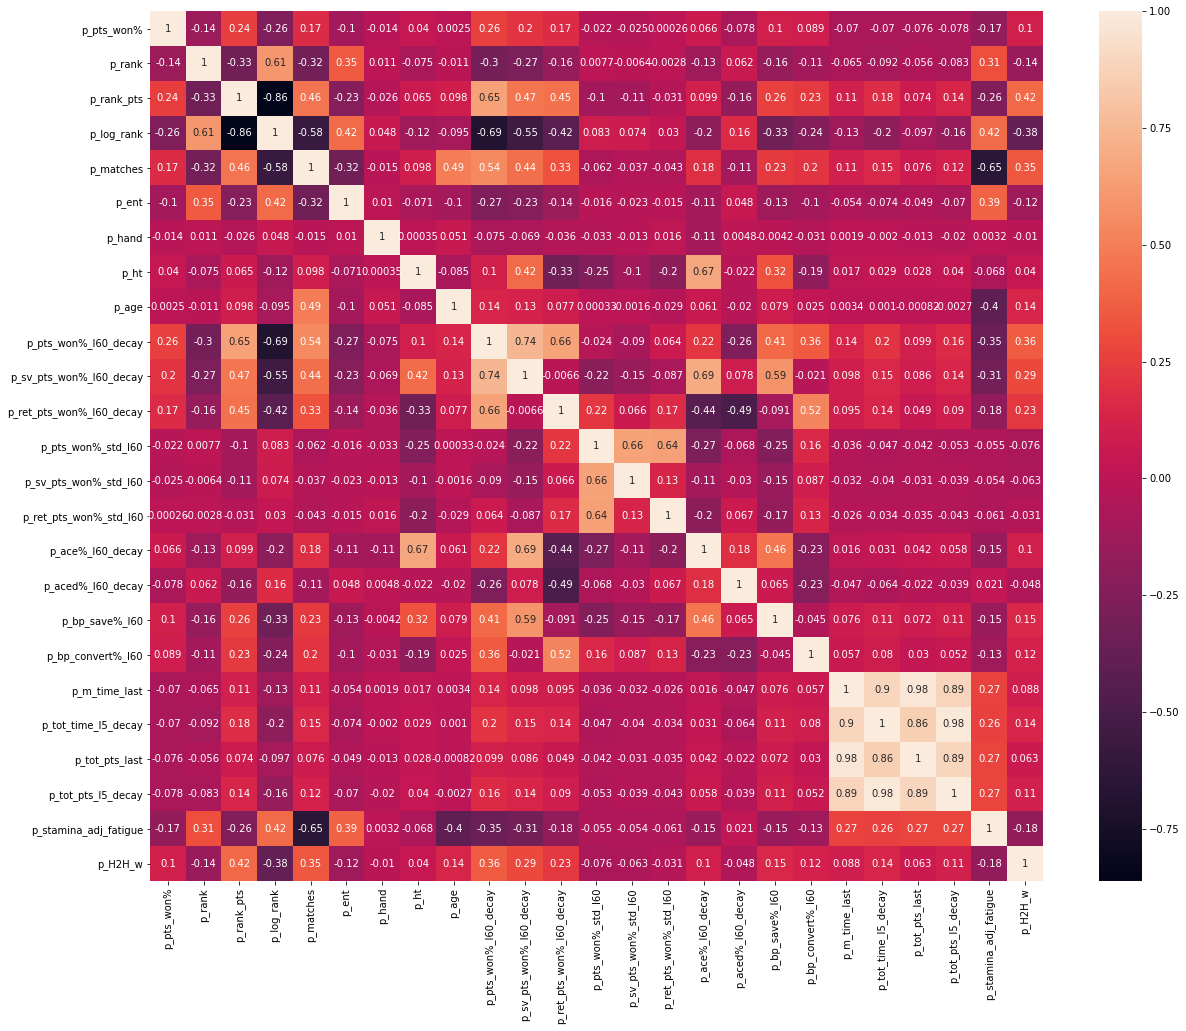

In [16]:
#Heatmap of correlations for pts_won% vs "differential features"
plt.subplots(figsize=(20,16))
sns.heatmap(df_filter_raw.corr(), annot = True);

Across the board, the feature correlations are directionally and proportionally very similar to those seen with the differential features. However, the magnitudes are generally substantially lower. This is not surprising at all, since a given tennis match involves two specific players whose relative strengths and weaknesses against each other are what will determine the outcome of a match (along with the luck component, of course). A player with a big serve, for example, can be largely neutralized by a great returner (and vice versa).

### Scatterplots

In [17]:
### Let's look at some scatterplots of putatively predictive differential features vs the target feature of pts won%
def scatterplots(columns, ncol=None, figsize=(20, 40)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.8)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'p_pts_won%', data=df_filter_raw, alpha=0.5)
        ax.set(xlabel=col, ylabel='p_pts_won%')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

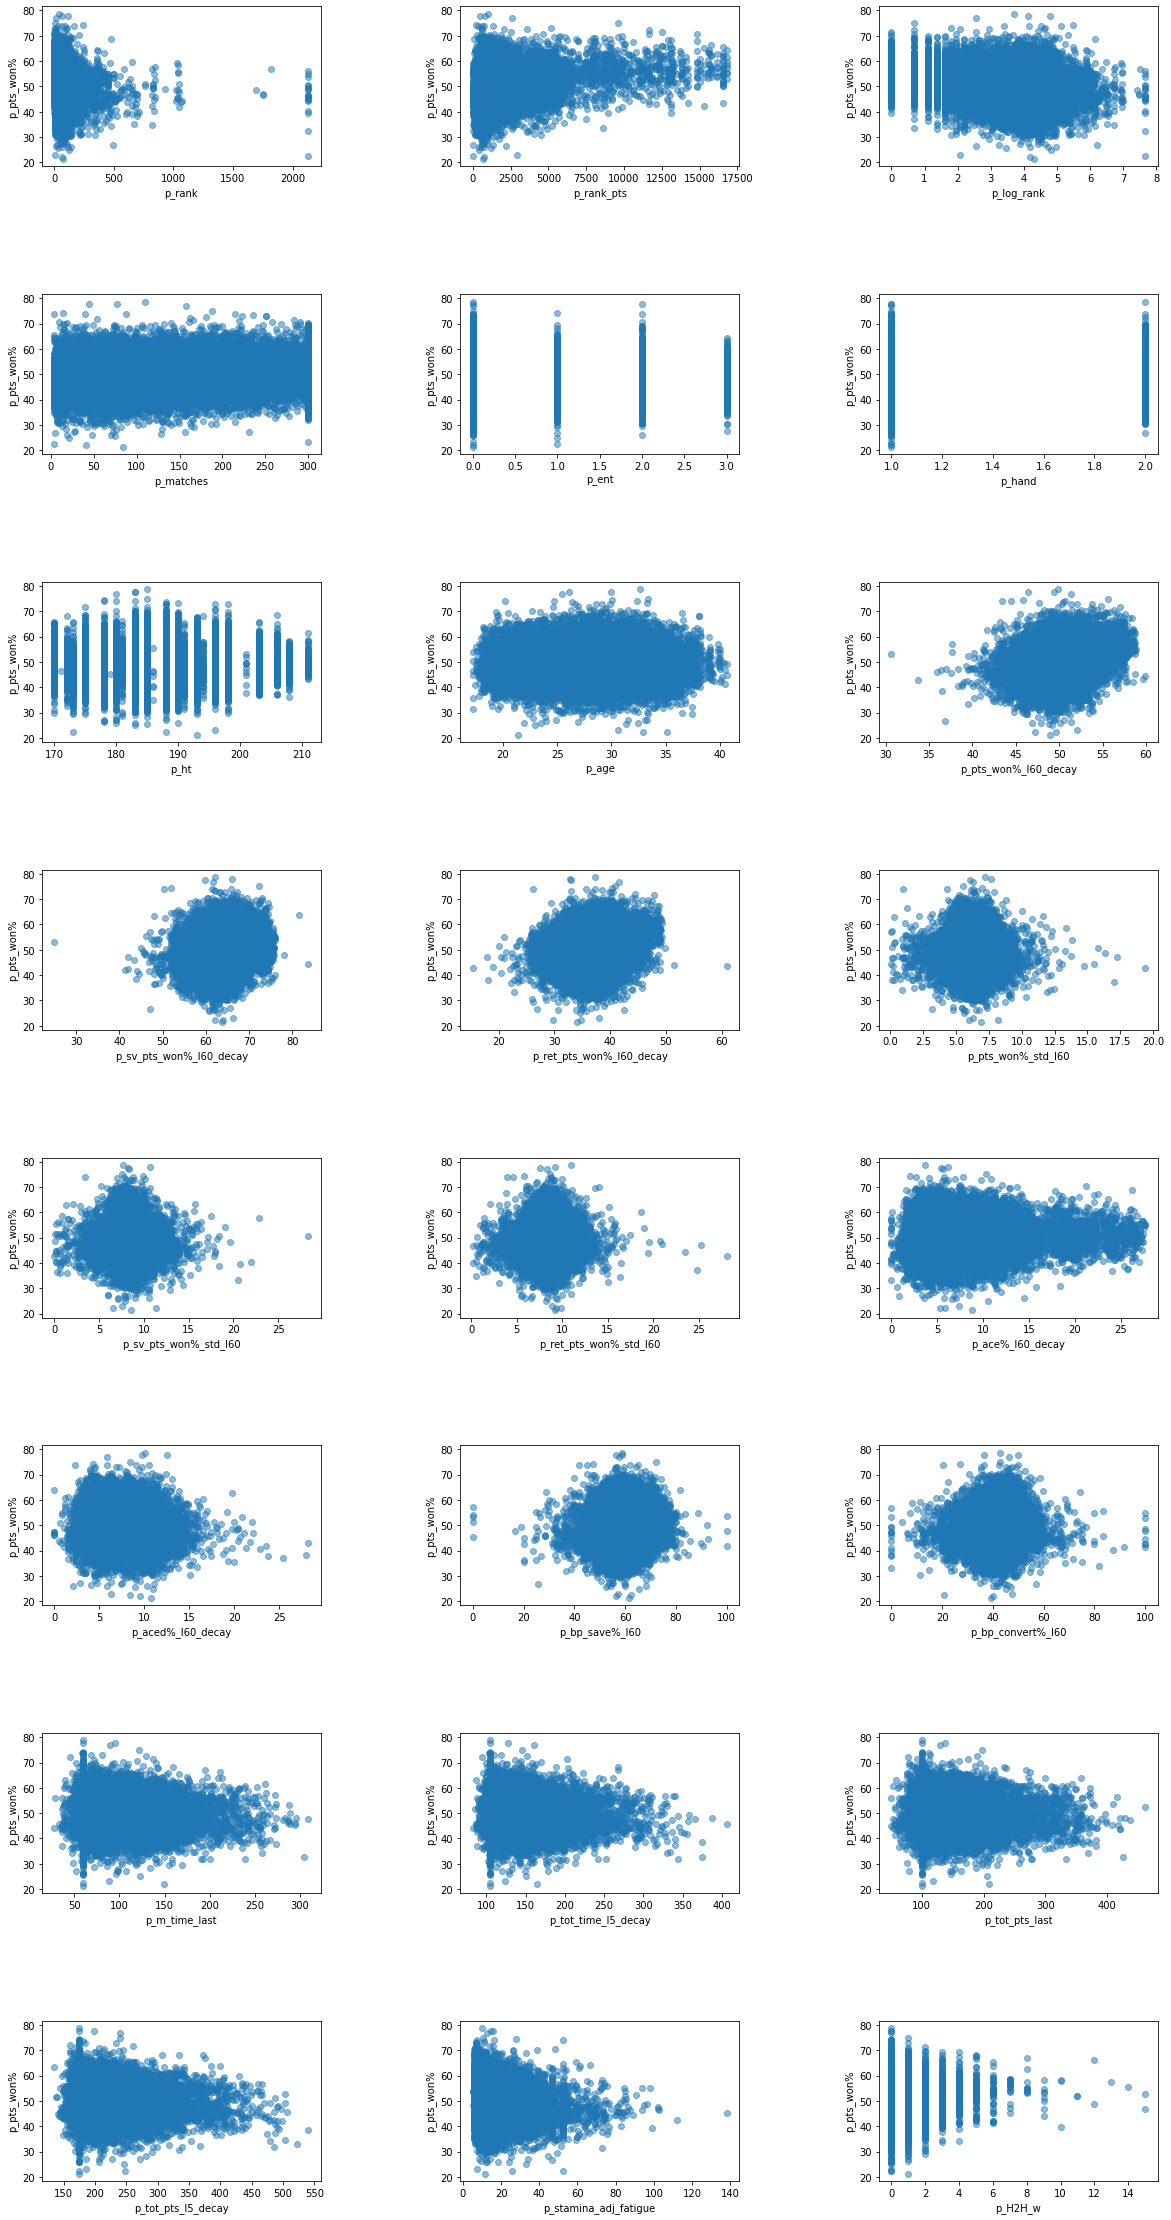

In [19]:
scatterplots(["p_rank", "p_rank_pts", "p_log_rank", "p_matches", "p_ent", "p_hand", "p_ht", "p_age", "p_pts_won%_l60_decay","p_sv_pts_won%_l60_decay", "p_ret_pts_won%_l60_decay", 'p_pts_won%_std_l60','p_sv_pts_won%_std_l60','p_ret_pts_won%_std_l60', "p_ace%_l60_decay", "p_aced%_l60_decay", "p_bp_save%_l60", "p_bp_convert%_l60", "p_m_time_last", "p_tot_time_l5_decay", "p_tot_pts_last", "p_tot_pts_l5_decay", "p_stamina_adj_fatigue", "p_H2H_w"], ncol=3)